In [1]:
import pandas as pd
import numpy as np
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import statistics

In [2]:
result = pd.read_csv("Doc2Vec Titles - Weighted Factor.csv", encoding = "ISO-8859-1")

In [3]:
y = result['Label']
del result['Label']

In [4]:
del result[ 'Unnamed: 0']
result.drop(result.index[[0]])

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
1,-0.001294,0.003404,-0.001227,0.000506,-0.000340,0.003344,-0.001729,-0.002544,-0.004084,0.007843,...,0.002817,0.009200,0.005817,-0.000007,-0.003598,-0.005208,-0.001883,-0.000041,0.005663,2.653061
2,0.009658,-0.009947,-0.005356,0.000006,0.006875,0.010328,-0.016886,-0.011126,-0.010848,-0.014954,...,0.022638,-0.006065,0.024322,-0.016470,0.005960,-0.010316,-0.006694,-0.000065,-0.041960,5.555556
3,0.004296,0.006316,0.011815,-0.001639,0.001203,0.002728,-0.013030,0.005086,0.002766,-0.005805,...,-0.015906,0.007273,0.008086,-0.001788,0.001948,-0.008862,-0.011240,0.014136,-0.006245,6.209150
4,-0.002163,0.005563,0.003652,0.002354,0.002788,0.002126,0.000664,0.005628,0.000247,0.001784,...,-0.001937,0.003677,0.003492,-0.003999,-0.008461,-0.017565,-0.006009,0.006691,-0.004138,1.330377
5,0.002181,-0.040099,-0.003733,-0.006015,0.015561,-0.038637,-0.004820,-0.014780,-0.001112,-0.004414,...,-0.041556,0.048237,0.015840,0.003343,-0.015214,-0.018954,-0.019778,-0.009822,0.005961,6.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,-0.002028,-0.000067,-0.002026,0.002360,-0.001204,0.001114,-0.003574,0.002100,0.003430,0.004309,...,0.003842,-0.002664,0.004417,0.004108,0.002644,-0.001050,-0.001201,-0.000912,0.003932,6.122449
2450,-0.002028,-0.000067,-0.002026,0.002360,-0.001204,0.001114,-0.003574,0.002100,0.003430,0.004309,...,0.003842,-0.002664,0.004417,0.004108,0.002644,-0.001050,-0.001201,-0.000912,0.003932,6.122449
2451,-0.000518,-0.009820,0.008393,0.004051,0.016970,0.005586,-0.004056,-0.002247,0.010091,-0.004079,...,-0.000150,0.001247,0.000261,0.008625,0.000110,-0.015375,-0.010646,0.000794,0.013640,2.777778
2452,-0.001058,-0.001996,0.000759,-0.000564,-0.001499,0.003161,-0.000525,0.004677,0.002401,-0.002597,...,-0.001494,-0.002517,0.000238,0.003309,-0.002394,0.002553,0.000649,-0.003360,-0.002406,17.142857


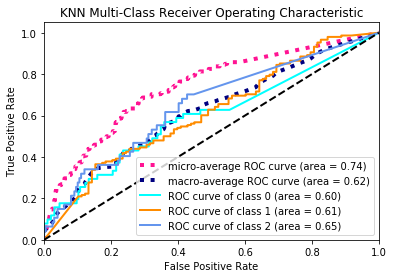

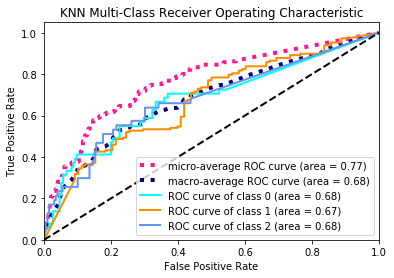

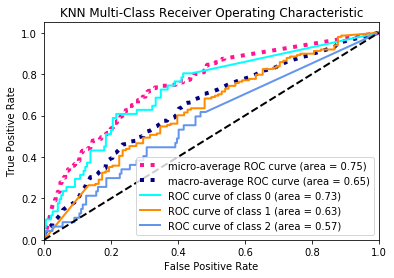

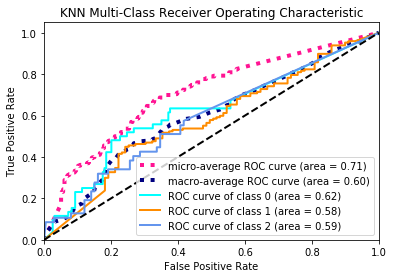

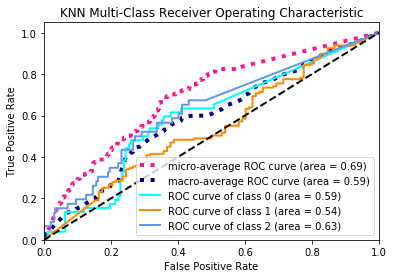

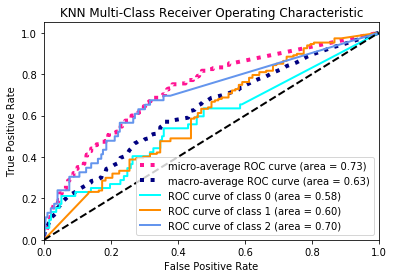

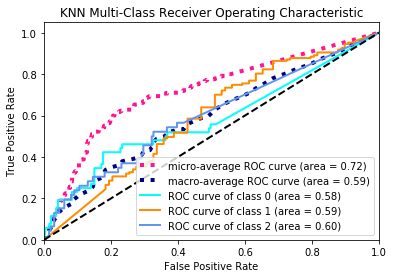

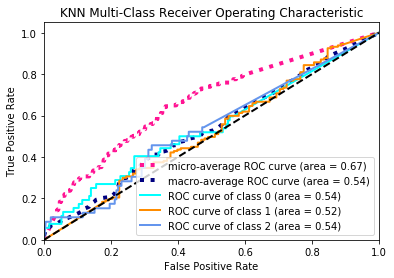

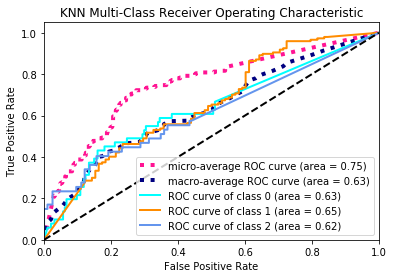

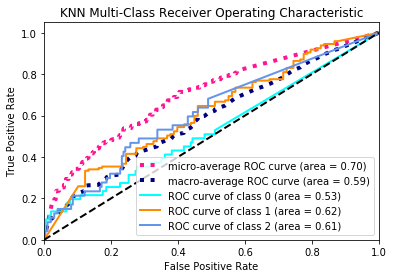

0.7213293622988901

In [5]:
#KNN ROC Curves (some code from #https://scikit-learn.org/stable/)
X_data = result
y_data = y

knn_macro_list = []
knn_micro_list = []
knn_auc_list = []
acc_knn_score1 = []


from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True)
for train_index, test_index in skf.split(result, y):
    train_news, test_news = result.iloc[train_index], result.iloc[test_index]
    train_labels, test_labels = y[train_index], y[test_index]
    
    le = preprocessing.LabelEncoder()
    le.fit(train_labels)
    classes_name=le.classes_
    le.transform(train_labels)
    
    # Binarize the output
    train_labels = le.transform(train_labels)
    test_labels = le.transform(test_labels)
    
    train_labels = label_binarize(train_labels, classes=[0,1,2])
    test_labels = label_binarize(test_labels, classes=[0,1,2])

    n_classes = train_labels.shape[1]
    
    #K-Nearest Neighbour
    knn = KNeighborsClassifier(n_neighbors=4,weights='distance',leaf_size=10)

    acc_knn_score1.append(knn.fit(train_news,train_labels).score(test_news, test_labels))
    
    # Learn to predict each class against the other
    knn_classifier = OneVsRestClassifier(knn)
    knn_score = knn_classifier.fit(train_news, train_labels).predict_proba(test_news)
    acc_knn_score = knn_classifier.score(test_news, test_labels)
    
    # Compute ROC curve and ROC area for each class
    knn_false_positive_rate = dict()
    knn_true_positive_rate = dict()
    knn_roc_auc = dict()
    for i in range(n_classes):
        knn_false_positive_rate[i], knn_true_positive_rate[i], _ = roc_curve(test_labels[:, i], knn_score[:, i])
        knn_roc_auc[i] = auc(knn_false_positive_rate[i], knn_true_positive_rate[i])

    # Compute micro-average ROC curve and ROC area
    knn_false_positive_rate["micro"], knn_true_positive_rate["micro"], _ = roc_curve(test_labels.ravel(), knn_score.ravel())
    knn_roc_auc["micro"] = auc(knn_false_positive_rate["micro"], knn_true_positive_rate["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_knn_fpr = np.unique(np.concatenate([knn_false_positive_rate[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_knn_tpr = np.zeros_like(all_knn_fpr)
    for i in range(n_classes):
        mean_knn_tpr += interp(all_knn_fpr, knn_false_positive_rate[i], knn_true_positive_rate[i])

    # Finally average it and compute AUC
    mean_knn_tpr /= n_classes

    knn_false_positive_rate["macro"] = all_knn_fpr
    knn_true_positive_rate["macro"] = mean_knn_tpr
    knn_roc_auc["macro"] = auc(knn_false_positive_rate["macro"], knn_true_positive_rate["macro"])

    # Plot all ROC curves
    lw=2
    plt.figure()
    plt.plot(knn_false_positive_rate["micro"], knn_true_positive_rate["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(knn_roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

    plt.plot(knn_false_positive_rate["macro"], knn_true_positive_rate["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(knn_roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(knn_false_positive_rate[i], knn_true_positive_rate[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, knn_roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('KNN Multi-Class Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    knn_macro_list.append(knn_roc_auc["macro"])
    knn_micro_list.append(knn_roc_auc["micro"])

max(knn_macro_list)
min(knn_macro_list)
np.mean(knn_macro_list)

max(knn_micro_list)
min(knn_micro_list)
np.mean(knn_micro_list)

In [10]:
#With Doc2vec Original Model Result
acc_knn_score1

[0.5141700404858299,
 0.5060728744939271,
 0.5222672064777328,
 0.5365853658536586,
 0.483739837398374,
 0.5142857142857142,
 0.47950819672131145,
 0.5737704918032787,
 0.48360655737704916,
 0.4918032786885246]

In [11]:
#With Doc2vec Original Model Result
np.mean(acc_knn_score1)

0.5105809563585401

C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


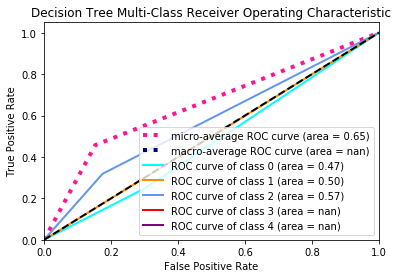

C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


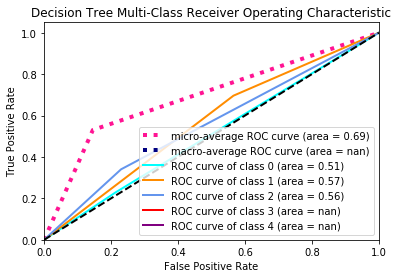

C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


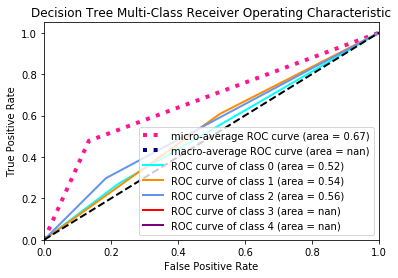

C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


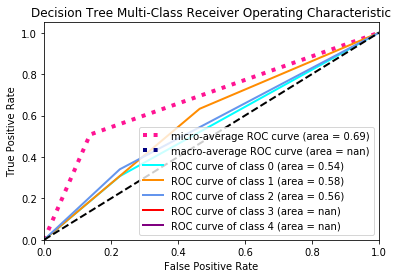

C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


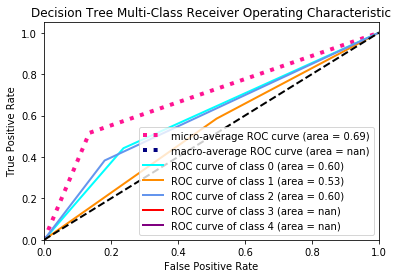

C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


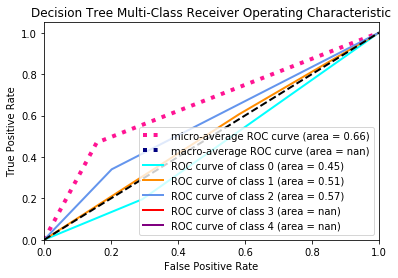

C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


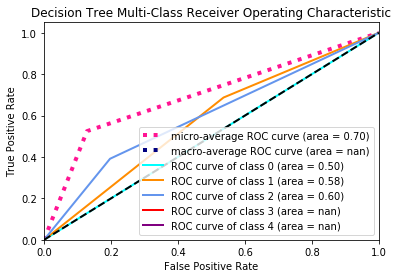

C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


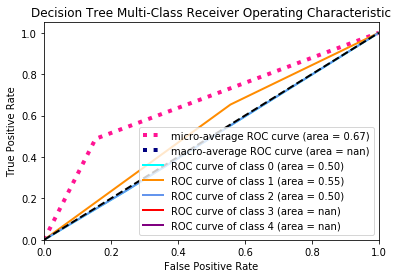

C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


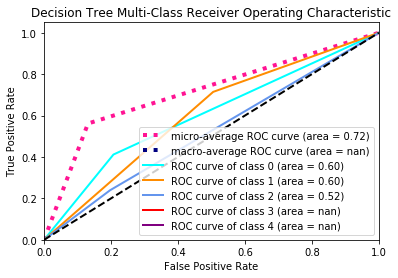

C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


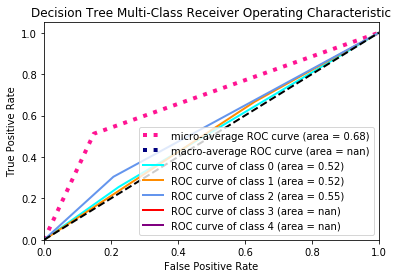

0.6811134195967706

In [8]:
#Decison Tree ROC Curves (some code from #https://scikit-learn.org/stable/)
decision_tree_macro_list = []
decision_tree_micro_list = []
decision_tree_auc_list = []
acc_decision_tree_score1 = []

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True)
for train_index, test_index in skf.split(result, y):
    train_news, test_news = result.iloc[train_index], result.iloc[test_index]
    train_labels, test_labels = y[train_index], y[test_index]

    
    le = preprocessing.LabelEncoder()
    le.fit(train_labels)
    classes_name=le.classes_
    le.transform(train_labels)
    
    # Binarize the output
    train_labels = le.transform(train_labels)
    test_labels = le.transform(test_labels)

    train_labels = label_binarize(train_labels, classes=[0,1,2,3,4])
    test_labels = label_binarize(test_labels, classes=[0,1,2,3,4])

    n_classes = train_labels.shape[1]

    #Decision Tree
    from sklearn.tree import DecisionTreeClassifier
    decision_tree = DecisionTreeClassifier(min_impurity_split=None, min_samples_split=2, min_samples_leaf=1)
    
    acc_decision_tree_score1.append(decision_tree.fit(train_news,train_labels).score(test_news, test_labels))
    
    # Learn to predict each class against the other
    decision_tree_classifier = OneVsRestClassifier(decision_tree)
    decision_tree_score = decision_tree_classifier.fit(train_news, train_labels).predict(test_news)
    acc_decision_tree_score = decision_tree_classifier.score(test_news, test_labels)

    # Compute ROC curve and ROC area for each class
    decision_tree_false_positive_rate = dict()
    decision_tree_true_positive_rate = dict()
    decision_tree_roc_auc = dict()
    for i in range(n_classes):
        decision_tree_false_positive_rate[i], decision_tree_true_positive_rate[i], _ = roc_curve(test_labels[:, i], decision_tree_score[:, i])
        decision_tree_roc_auc[i] = auc(decision_tree_false_positive_rate[i], decision_tree_true_positive_rate[i])

    # Compute micro-average ROC curve and ROC area
    decision_tree_false_positive_rate["micro"], decision_tree_true_positive_rate["micro"], _ = roc_curve(test_labels.ravel(), decision_tree_score.ravel())
    decision_tree_roc_auc["micro"] = auc(decision_tree_false_positive_rate["micro"], decision_tree_true_positive_rate["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_decision_tree_fpr = np.unique(np.concatenate([decision_tree_false_positive_rate[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_decision_tree_tpr = np.zeros_like(all_decision_tree_fpr)
    for i in range(n_classes):
        mean_decision_tree_tpr += interp(all_decision_tree_fpr, decision_tree_false_positive_rate[i], decision_tree_true_positive_rate[i])

    # Finally average it and compute AUC
    mean_decision_tree_tpr /= n_classes

    decision_tree_false_positive_rate["macro"] = all_decision_tree_fpr
    decision_tree_true_positive_rate["macro"] = mean_decision_tree_tpr
    decision_tree_roc_auc["macro"] = auc(decision_tree_false_positive_rate["macro"], decision_tree_true_positive_rate["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(decision_tree_false_positive_rate["micro"], decision_tree_true_positive_rate["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(decision_tree_roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(decision_tree_false_positive_rate["macro"], decision_tree_true_positive_rate["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(decision_tree_roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(decision_tree_false_positive_rate[i], decision_tree_true_positive_rate[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, decision_tree_roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Decision Tree Multi-Class Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    decision_tree_macro_list.append(decision_tree_roc_auc["macro"])
    decision_tree_micro_list.append(decision_tree_roc_auc["micro"])

max(decision_tree_macro_list)
min(decision_tree_macro_list)
np.mean(decision_tree_macro_list)

max(decision_tree_micro_list)
min(decision_tree_micro_list)
np.mean(decision_tree_micro_list)

In [9]:
#With Doc2vec original Model Result
acc_decision_tree_score1

[0.46963562753036436,
 0.47368421052631576,
 0.44129554655870445,
 0.508130081300813,
 0.43089430894308944,
 0.46122448979591835,
 0.45491803278688525,
 0.5122950819672131,
 0.5,
 0.4918032786885246]

In [10]:
#With Doc2vec original Model Result
np.mean(acc_decision_tree_score1)

0.4743880658097829

C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


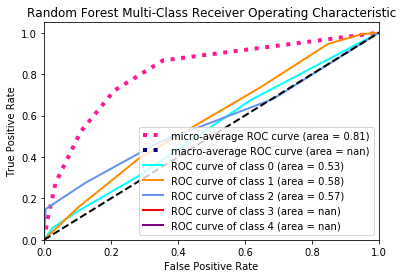

C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


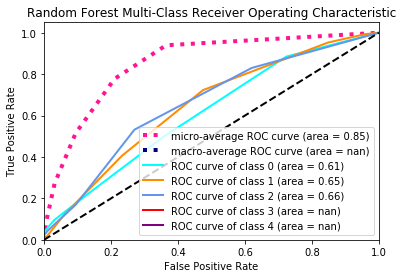

C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


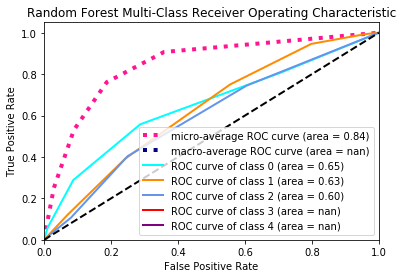

C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


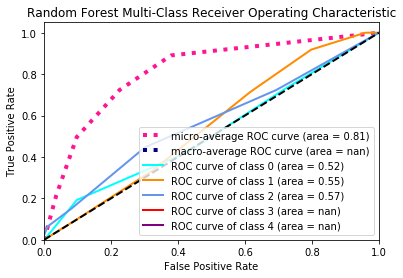

C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


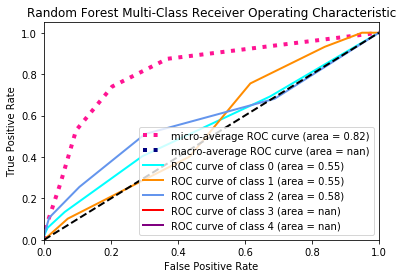

C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


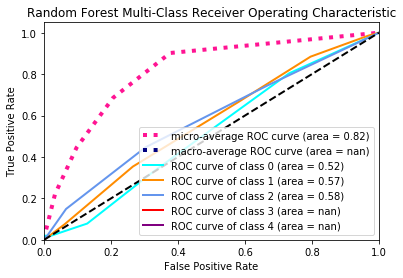

C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


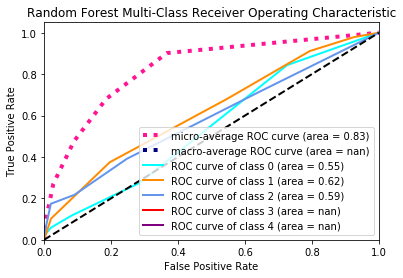

C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


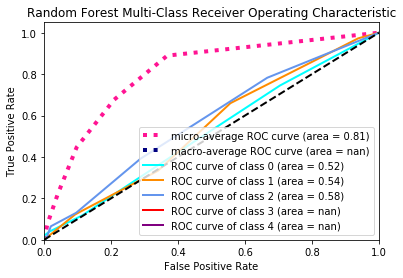

C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


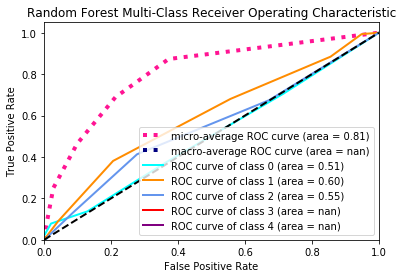

C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
C:\Users\hag75415\AppData\Local\Continuum\anaconda3.1\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


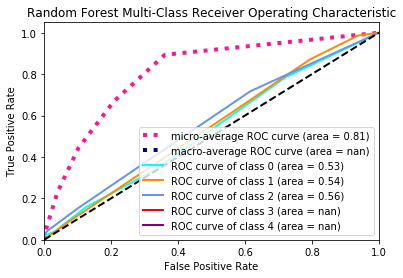

0.8213954521754937

In [11]:
#Random Forest ROC Curves (some code from #https://scikit-learn.org/stable/)
random_forest_macro_list = []
random_forest_micro_list = []
random_forest_auc_list = []
acc_random_forest_score1 = []

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True)
for train_index, test_index in skf.split(result, y):
    train_news, test_news = result.iloc[train_index], result.iloc[test_index]
    train_labels, test_labels = y[train_index], y[test_index]
    
    le = preprocessing.LabelEncoder()
    le.fit(train_labels)
    classes_name=le.classes_
    le.transform(train_labels)
    
    # Binarize the output
    train_labels = le.transform(train_labels)
    test_labels = le.transform(test_labels)

    train_labels = label_binarize(train_labels, classes=[0,1,2,3,4])
    test_labels = label_binarize(test_labels, classes=[0,1,2,3,4])

    n_classes = train_labels.shape[1]

    #Random Forest
    from sklearn.ensemble import RandomForestClassifier
    random_forest = RandomForestClassifier(min_impurity_split=None, n_estimators=5, random_state=0,)
    
    acc_random_forest_score1.append(random_forest.fit(train_news,train_labels).score(test_news, test_labels))
    
    # Learn to predict each class against the other
    random_forest_classifier = OneVsRestClassifier(random_forest)
    random_forest_score = random_forest_classifier.fit(train_news, train_labels).predict_proba(test_news)
    acc_random_forest_score = random_forest_classifier.score(test_news, test_labels)

    # Compute ROC curve and ROC area for each class
    random_forest_false_positive_rate = dict()
    random_forest_true_positive_rate = dict()
    random_forest_roc_auc = dict()
    for i in range(n_classes):
        random_forest_false_positive_rate[i], random_forest_true_positive_rate[i], _ = roc_curve(test_labels[:, i], random_forest_score[:, i])
        random_forest_roc_auc[i] = auc(random_forest_false_positive_rate[i], random_forest_true_positive_rate[i])

    # Compute micro-average ROC curve and ROC area
    random_forest_false_positive_rate["micro"], random_forest_true_positive_rate["micro"], _ = roc_curve(test_labels.ravel(), random_forest_score.ravel())
    random_forest_roc_auc["micro"] = auc(random_forest_false_positive_rate["micro"], random_forest_true_positive_rate["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_random_forest_fpr = np.unique(np.concatenate([random_forest_false_positive_rate[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_random_forest_tpr = np.zeros_like(all_random_forest_fpr)
    for i in range(n_classes):
        mean_random_forest_tpr += interp(all_random_forest_fpr, random_forest_false_positive_rate[i], random_forest_true_positive_rate[i])

    # Finally average it and compute AUC
    mean_random_forest_tpr /= n_classes

    random_forest_false_positive_rate["macro"] = all_random_forest_fpr
    random_forest_true_positive_rate["macro"] = mean_random_forest_tpr
    random_forest_roc_auc["macro"] = auc(random_forest_false_positive_rate["macro"], random_forest_true_positive_rate["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(random_forest_false_positive_rate["micro"], random_forest_true_positive_rate["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(random_forest_roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(random_forest_false_positive_rate["macro"], random_forest_true_positive_rate["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(random_forest_roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(random_forest_false_positive_rate[i], random_forest_true_positive_rate[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, random_forest_roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Random Forest Multi-Class Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    random_forest_macro_list.append(random_forest_roc_auc["macro"])
    random_forest_micro_list.append(random_forest_roc_auc["micro"])

max(random_forest_macro_list)
min(random_forest_macro_list)
np.mean(random_forest_macro_list)

max(random_forest_micro_list)
min(random_forest_micro_list)
np.mean(random_forest_micro_list)

In [12]:
#With Doc2Vec Original Model Result
acc_random_forest_score1

[0.47368421052631576,
 0.4493927125506073,
 0.4898785425101215,
 0.44308943089430897,
 0.46747967479674796,
 0.4,
 0.430327868852459,
 0.4672131147540984,
 0.4385245901639344,
 0.430327868852459]

In [13]:
#With Doc2Vec Original Model Result
np.mean(acc_random_forest_score1)

0.4489918013901052